# II. Reconnaissance de chiffres manuscrits

[]

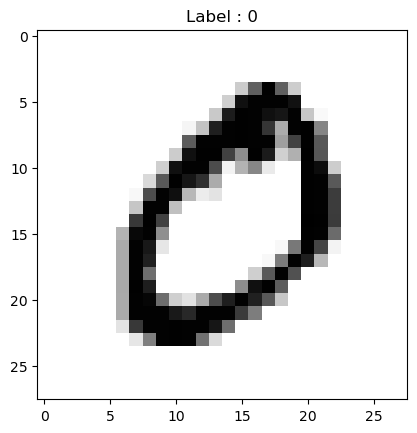

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
## if local file mnist-original.mat exist

'''
from scipy.io import loadmat

mnist = loadmat('mnist-original.mat')
mnist = mnist['data'].transpose()
plt.imshow(mnist[1,:].reshape((28,28)))
'''

#otherwise download from internet
from sklearn.datasets import fetch_openml

X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = y.astype(int)
plt.imshow(X[1,:].reshape(28,28),cmap=matplotlib.cm.binary)
plt.title("Label : {}".format(y[1]))
plt.plot()

## Découpage du jeu de données

In [2]:
X_train, y_train, X_test, y_test = X[:60000],y[:60000],X[60000:],y[60000:]

shuffle_index = np.random.permutation(60000)

X_train , y_train = X_train[shuffle_index], y_train[shuffle_index] 

## Pré-traitement : construction one-fit all

In [3]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test==5)

## Premier modèle : perceptron multicouche (20,20)

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import *

mlp = MLPClassifier(hidden_layer_sizes=(20,20))

mlp.fit(X_train, y_train_5)

pred = mlp.predict(X_test)
print(confusion_matrix(y_test_5,pred))

[[9080   28]
 [  36  856]]


In [5]:
print(classification_report(y_test_5,pred))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00      9108
        True       0.97      0.96      0.96       892

    accuracy                           0.99     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.99      0.99      0.99     10000



In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(mlp, X_train, y_train_5,cv=3, scoring='accuracy')

array([0.98905, 0.9917 , 0.9887 ])

In [8]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30))
mlp.fit(X_train, y_train_5)

pred = mlp.predict(X_test)
print(classification_report(y_test_5,pred))

print(cross_val_score(mlp, X_train, y_train_5,cv=3, scoring='accuracy'))

              precision    recall  f1-score   support

       False       0.99      1.00      1.00      9108
        True       0.98      0.94      0.96       892

    accuracy                           0.99     10000
   macro avg       0.99      0.97      0.98     10000
weighted avg       0.99      0.99      0.99     10000

[0.99165 0.99375 0.98715]


### 1
The idea is the same as in the previous exercise: for the validation set, we reach the same plateau when varying the number of neurons because the statistics are already very high and close to the maximum value, with very little variation. This indicates that it is not worth adding many neurons to achieve a better result, since with a minimal amount, such as (10,10), we already obtain a result very close to what we would get with (30,30), but at a higher computational cost.

### 2
And the maximum number of iterations also does not significantly affect the result, just like in the previous exercise. This is because once the model reaches a point where there is no convergence but the variation in parameters is minimal, the model remains almost the same, yielding consistent results.

### Convergence du modèle

In [ ]:
def rotate(img, theta):
    
    rot = np.array([[np.cos(theta), -1*np.sin(theta)],[np.sin(theta),np.cos(theta)]]) # rotation matrix
    
    new_img = np.ones((28,28))
    img = img.reshape((28,28)) # in case img is not shaped correctly

    coords = [(i,j) for i in range(28) for j in range(28)]
    # for each cell/pixel in new image calculate the rotated coordinate and assign pixel value to the one of the corresponding rotated cell
    for i,j in coords:
        new_coord = rot @ np.array([[j-13.5],[13.5-i]]) # change coordinate in (x,y) space, reproject with a rotation of theta angle
        new_coord = np.ceil(new_coord * np.array([[1],[-1]]) + np.array([[13.5],[13.5]])) # change back (x,y) -> to cell coordinate (j,i)
        
        if np.all(new_coord< np.array([[28],[28]])) & np.all(new_coord >= np.array([[0],[0]])): # check if new coordinate is within bounds to prevent errors
            new_img[i,j] = img[int(new_coord[1,0]),int(new_coord[0,0])] # assign (i,j) to (j',i') (note coordinate is inverted on purpose)
    return new_img


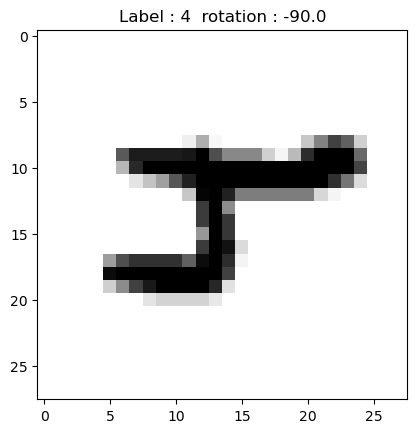

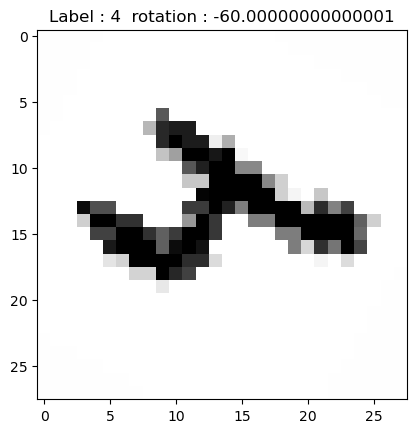

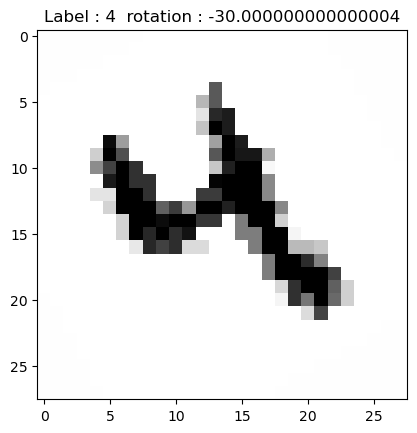

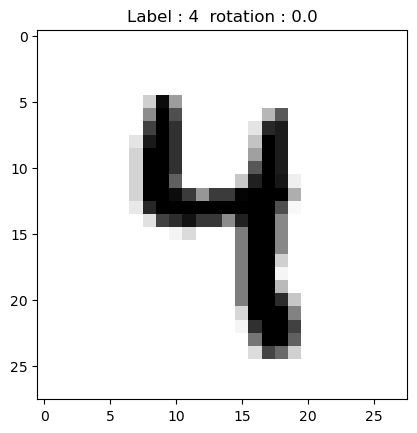

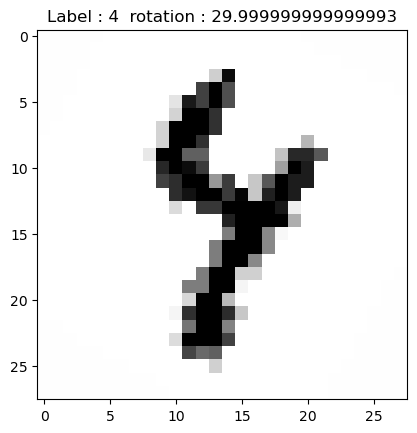

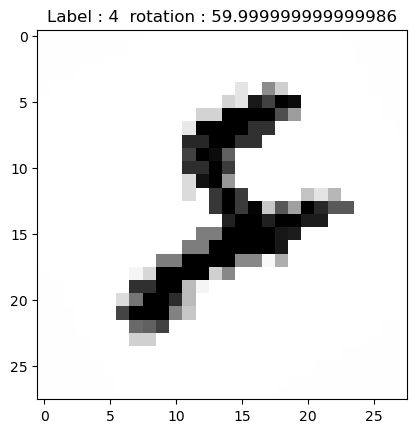

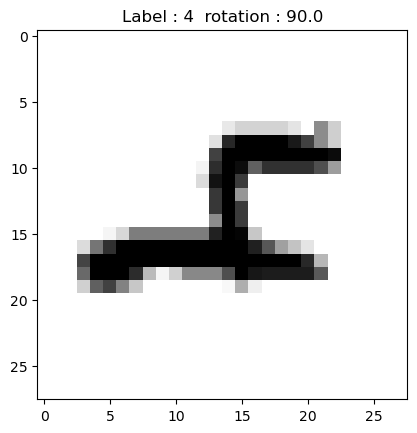

In [38]:
im_test = X_train[7,:]
im_test_lab = y_train[7]
for deg in np.linspace(-np.pi/2,np.pi/2,7):
    plt.figure()
    plt.imshow(rotate(im_test,deg),cmap=matplotlib.cm.binary)
    #plt.plot(np.linspace(0,2*np.pi,100), [np.cos(i) for i in np.linspace(0,2*np.pi,100)])
    plt.title("Label : {}  rotation : {}".format(im_test_lab,deg*180/np.pi))

In [7]:

# re-run if needed
'''
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import *
from sklearn.datasets import fetch_openml

#fetch data
X, y = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)
y = y.astype(int)

#split
X_train, y_train, X_test, y_test = X[:60000],y[:60000],X[60000:],y[60000:]
shuffle_index = np.random.permutation(60000)
X_train , y_train = X_train[shuffle_index], y_train[shuffle_index] 

#one vs all
y_train_5 = (y_train == 5)
y_test_5 = (y_test==5)

#create the model
mlp = MLPClassifier(hidden_layer_sizes=(20,20))

# train
mlp.fit(X_train, y_train_5)
'''


100%|██████████| 40/40 [11:30<00:00, 17.25s/it]


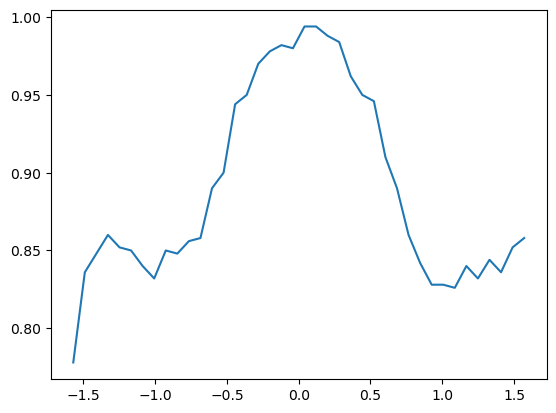

In [40]:
from tqdm import *
accuracy = []

angle_step = 40
test_sample_size = 500
degs = np.linspace(-np.pi/2,np.pi/2,angle_step)

for deg in tqdm(degs):
    new_set = np.zeros((len(X_test[:test_sample_size]),784))
    for i in tqdm(range(len(X_test[:test_sample_size]))):
        new_set[i,:] = rotate(X_test[i,:],deg).reshape((-1))

    pred = mlp.predict(new_set)
    accuracy.append(accuracy_score(y_test_5[:test_sample_size],pred))

plt.plot(degs,accuracy)

Notably, when we apply rotations, either counterclockwise or clockwise, the model performs worse. This shows that the way the image is presented affects our final result in terms of image prediction. Therefore, it is important to evaluate these parameters as well when training the model to achieve better performance.